### Packages Required

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

c:\Users\surya\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Data Exploration

In [37]:
price = pd.read_csv("crsp_dataset.csv")

In [38]:
price.count().max()

24365797

In [39]:
price.head()

,PERMNO,HdrCUSIP,Ticker,PERMCO,SICCD,DlyCalDt,DlyPrc,DlyRet,DlyRetx,DlyVol,DlyPrcVol,ShrOut
0,10001,36720410,EGAS,7953,4925,20100104,10.25,-0.004854,-0.004854,18500.0,189625.0,4361.0
1,10001,36720410,EGAS,7953,4925,20100105,10.19,-0.005854,-0.005854,23200.0,236408.0,4361.0
2,10001,36720410,EGAS,7953,4925,20100106,10.31,0.011776,0.011776,18700.0,192797.0,4361.0
3,10001,36720410,EGAS,7953,4925,20100107,9.96,-0.033948,-0.033948,29200.0,290832.0,4361.0
4,10001,36720410,EGAS,7953,4925,20100108,10.34,0.038153,0.038153,25100.0,259534.0,4361.0


In [40]:
price.drop(columns=["PERMCO","DlyPrcVol","HdrCUSIP"], inplace=True)

In [41]:
price.rename(columns={
    "Ticker":"TICKER","DlyCalDt":"date","DlyPrc":"PRC","DlyVol":"VOL","ShrOut":"SHROUT",
    "DlyRet":"RET","DlyRetx":"RETX"}, inplace=True)

In [42]:
price.isnull().sum()

PERMNO         0
TICKER    201060
SICCD          0
date           0
PRC       200238
RET       209333
RETX      209333
VOL       206640
SHROUT      6472
dtype: int64

In [43]:
print("Original dataset size: ", len(price))
print("Original number of stocks: ", len(set(price['PERMNO'])))

Original dataset size:  24365797
Original number of stocks:  15402


In [44]:
#preprocessing
price['_date'] = pd.to_datetime(price['date'], format = '%Y%m%d')
price['turnover'] = price['VOL']/price['SHROUT']

#negative price stocks
neg_price = price[price['PRC'] <= 0]        #delete stocks with negative price (will be problematic when trading)
neg_price_list = list(set(neg_price['PERMNO']))

#low trading volume
low_vol = price[price['turnover'] <= 0.1]   #if the daily trading volume is less than 0.1% of its total shares outstanding
low_vol_list = list(set(low_vol['PERMNO']))
for item in low_vol_list:
    temp = low_vol.loc[low_vol['PERMNO'] == item]
    if len(temp) < 100:                     #avoid deleting too many stocks (data collection error or temporary derail)
        low_vol_list.remove(item)

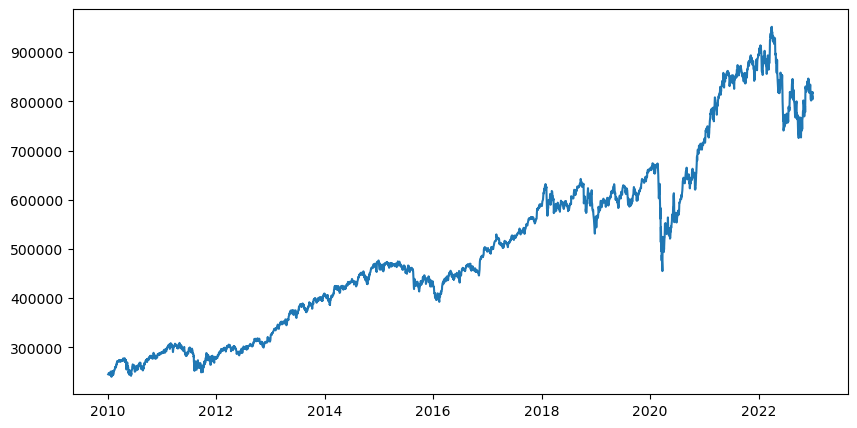

In [45]:
plt.figure(figsize=(10,5))
grouped = price.groupby(['_date'])['PRC'].sum().reset_index()
plt.plot(grouped._date, grouped.PRC)
plt.show()

In [46]:
print(len(neg_price_list))
print(len(low_vol))

4658
1073794


In [47]:
price.head()

,PERMNO,TICKER,SICCD,date,PRC,RET,RETX,VOL,SHROUT,_date,turnover
0,10001,EGAS,4925,20100104,10.25,-0.004854,-0.004854,18500.0,4361.0,2010-01-04,4.242146
1,10001,EGAS,4925,20100105,10.19,-0.005854,-0.005854,23200.0,4361.0,2010-01-05,5.319881
2,10001,EGAS,4925,20100106,10.31,0.011776,0.011776,18700.0,4361.0,2010-01-06,4.288007
3,10001,EGAS,4925,20100107,9.96,-0.033948,-0.033948,29200.0,4361.0,2010-01-07,6.695712
4,10001,EGAS,4925,20100108,10.34,0.038153,0.038153,25100.0,4361.0,2010-01-08,5.755561


### Exclude Data Points 

In [48]:
#stocks that we want to exclude
final_list = list( set(neg_price_list) | set(low_vol_list))
#final dataset for price
stock_price = price.loc[price['PERMNO'].isin(final_list) == False]

In [49]:
print("Dataset size: ", len(stock_price))
print("Number of stocks: ", len(set(stock_price['PERMNO'])))

Dataset size:  14398448
Number of stocks:  7525


In [50]:
#set training set sample period for clsutering analysis, from 2010/01/01 to 2015/12/31
#and set testing dataset from 2016/01/01 to 2019/12/31
price_train = stock_price.loc[stock_price['date'] < 20160101]
price_test = stock_price.loc[stock_price['date'] >= 20160101]

In [51]:
stock_price.isnull().sum()

PERMNO           0
TICKER      110648
SICCD            0
date             0
PRC         112347
RET         116727
RETX        116727
VOL         113094
SHROUT         814
_date            0
turnover    113094
dtype: int64

### Data Manipulation

In [52]:
#get the pivot table, with stock permno as index and datetime as columns
df_price = pd.pivot_table(price_train, values = 'PRC', index = 'PERMNO', columns = 'date')
df_price = df_price.add_prefix('price_')
#last step, delete stocks with more than half nan price for clustering
df_price = df_price.dropna(thresh = len(df_price.columns)//2)
df_price = df_price.fillna(method = 'ffill', axis = 1, limit = 5)

C:\Users\surya\AppData\Local\Temp\ipykernel_13636\1221759848.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_price = df_price.fillna(method = 'ffill', axis = 1, limit = 5)


In [53]:
df_price.head()

date,price_20100104,price_20100105,price_20100106,price_20100107,price_20100108,price_20100111,price_20100112,price_20100113,price_20100114,price_20100115,...,price_20151217,price_20151218,price_20151221,price_20151222,price_20151223,price_20151224,price_20151228,price_20151229,price_20151230,price_20151231
PERMNO,,,,,,,,,,,,,,,,,,,,,
10026,40.20,38.70,37.03,37.9200,38.0600,37.85,38.33,39.2300,38.9800,39.08,...,114.37,112.69,112.92,114.530,115.90,118.21,117.64,119.37,119.25,116.67
10032,29.41,30.06,30.18,30.1300,29.7400,29.15,28.80,28.6600,28.7900,28.20,...,35.26,34.99,35.22,35.080,35.95,36.05,35.67,35.92,35.46,34.92
10044,8.23,8.31,8.35,8.4780,8.4248,8.74,8.92,8.7560,8.7701,8.50,...,10.21,10.39,10.36,10.655,10.80,10.74,10.32,10.50,10.38,10.75
10065,10.25,10.27,10.31,10.3205,10.3200,10.36,10.24,10.3205,10.3800,10.26,...,12.74,12.62,12.62,12.700,12.88,12.89,12.82,12.94,12.94,12.83
10104,24.85,24.82,24.46,24.3800,24.6800,24.69,24.56,24.8000,25.3400,25.24,...,36.93,36.35,36.42,36.590,36.93,37.01,36.79,37.04,36.92,36.53


In [54]:
df_price.fillna(df_price.mean(),axis=0, inplace=True)

In [55]:
df_price.isnull().sum()

date
price_20100104    0
price_20100105    0
price_20100106    0
price_20100107    0
price_20100108    0
                 ..
price_20151224    0
price_20151228    0
price_20151229    0
price_20151230    0
price_20151231    0
Length: 1510, dtype: int64

In [56]:
#get the list permno for further data extraction
permno = list(df_price.index)
with open('permno_list.txt', 'w') as filehandle:    #write to file
    for listitem in permno:
        filehandle.write('%i\n' % listitem)

In [57]:
print("number of columns",len(df_price.columns))
print("Number of training stocks: ", len(df_price))

number of columns 1510
Number of training stocks:  3510


In [58]:
df_price.to_csv('stock_price_table.csv')

In [5]:
#import financial ratios dataset
ratios = pd.read_csv("ratios_data.csv")
ratios.head()

,permno,adate,qdate,public_date,bm,pe_exi,npm,cfm,roa,roe,...,totdebt_invcap,capital_ratio,debt_ebitda,lt_debt,cash_debt,fcf_ocf,de_ratio,at_turn,staff_sale,ptb
0,54594,20090531.0,20091130,20100131,1.077,16.433,0.041,0.073,0.095,0.079,...,0.404,0.349,3.247,0.541,0.089,0.774,0.991,1.001,0.0,1.152
1,54594,20090531.0,20091130,20100228,1.077,16.085,0.041,0.073,0.095,0.079,...,0.404,0.349,3.247,0.541,0.089,0.774,0.991,1.001,0.0,1.128
2,54594,20090531.0,20091130,20100331,1.077,17.603,0.041,0.073,0.095,0.079,...,0.404,0.349,3.247,0.541,0.089,0.774,0.991,1.001,0.0,1.237
3,54594,20090531.0,20100228,20100430,0.898,19.349,0.037,0.067,0.086,0.067,...,0.360,0.324,3.215,0.535,0.089,0.851,0.897,0.987,0.0,1.197
4,54594,20090531.0,20100228,20100531,0.898,15.635,0.037,0.067,0.086,0.067,...,0.360,0.324,3.215,0.535,0.089,0.851,0.897,0.987,0.0,0.968


In [6]:
ratios = ratios.loc[ratios.adate.dropna().index]
ratios.fillna(ratios.mean(), inplace=True)

In [7]:
#since the public date is already two month behind qdate (defined to be), we do not need to lag the data anymore
ratios['_date'] = pd.to_datetime(ratios['public_date'], format = '%Y%m%d').dt.to_period('M')
#select only training period
ratios_train = ratios.loc[(ratios['public_date'] >= 20151231) & (ratios['public_date']<= 20151231)]
ratios_train.tail()

,permno,adate,qdate,public_date,bm,pe_exi,npm,cfm,roa,roe,...,capital_ratio,debt_ebitda,lt_debt,cash_debt,fcf_ocf,de_ratio,at_turn,staff_sale,ptb,_date
571977,82678,20141231.0,20150930,20151231,0.072,-34.058,-0.265000,-0.241000,-0.359,-1.761,...,0.654,-1.086,0.339,-0.465,-6.559227e+09,5.574,1.480000,0.000000,9.063,2015-12
572127,12615,20141231.0,20150930,20151231,0.914,12.617,0.132000,0.160000,0.123,0.121,...,0.000,0.000,0.000,0.507,9.130000e-01,0.263,0.772000,0.012000,1.495,2015-12
572239,14060,20141231.0,20150930,20151231,2.386,-576.800,-30.220000,-24.056000,-0.583,-0.931,...,0.115,-0.138,0.316,-2.283,-6.559227e+09,0.411,0.024000,0.000000,0.308,2015-12
572378,12667,20141231.0,20150930,20151231,0.046,-3.716,-15.686034,-15.471987,-1.091,-1.737,...,0.000,0.000,0.000,-2.641,-6.559227e+09,0.266,0.806788,0.186354,21.547,2015-12
572636,14406,20141231.0,20150930,20151231,1.023,-5.173,-0.102000,-0.003000,0.079,-0.083,...,0.509,6.326,0.660,0.049,7.080000e-01,1.570,0.285000,0.000000,1.078,2015-12


<Axes: >

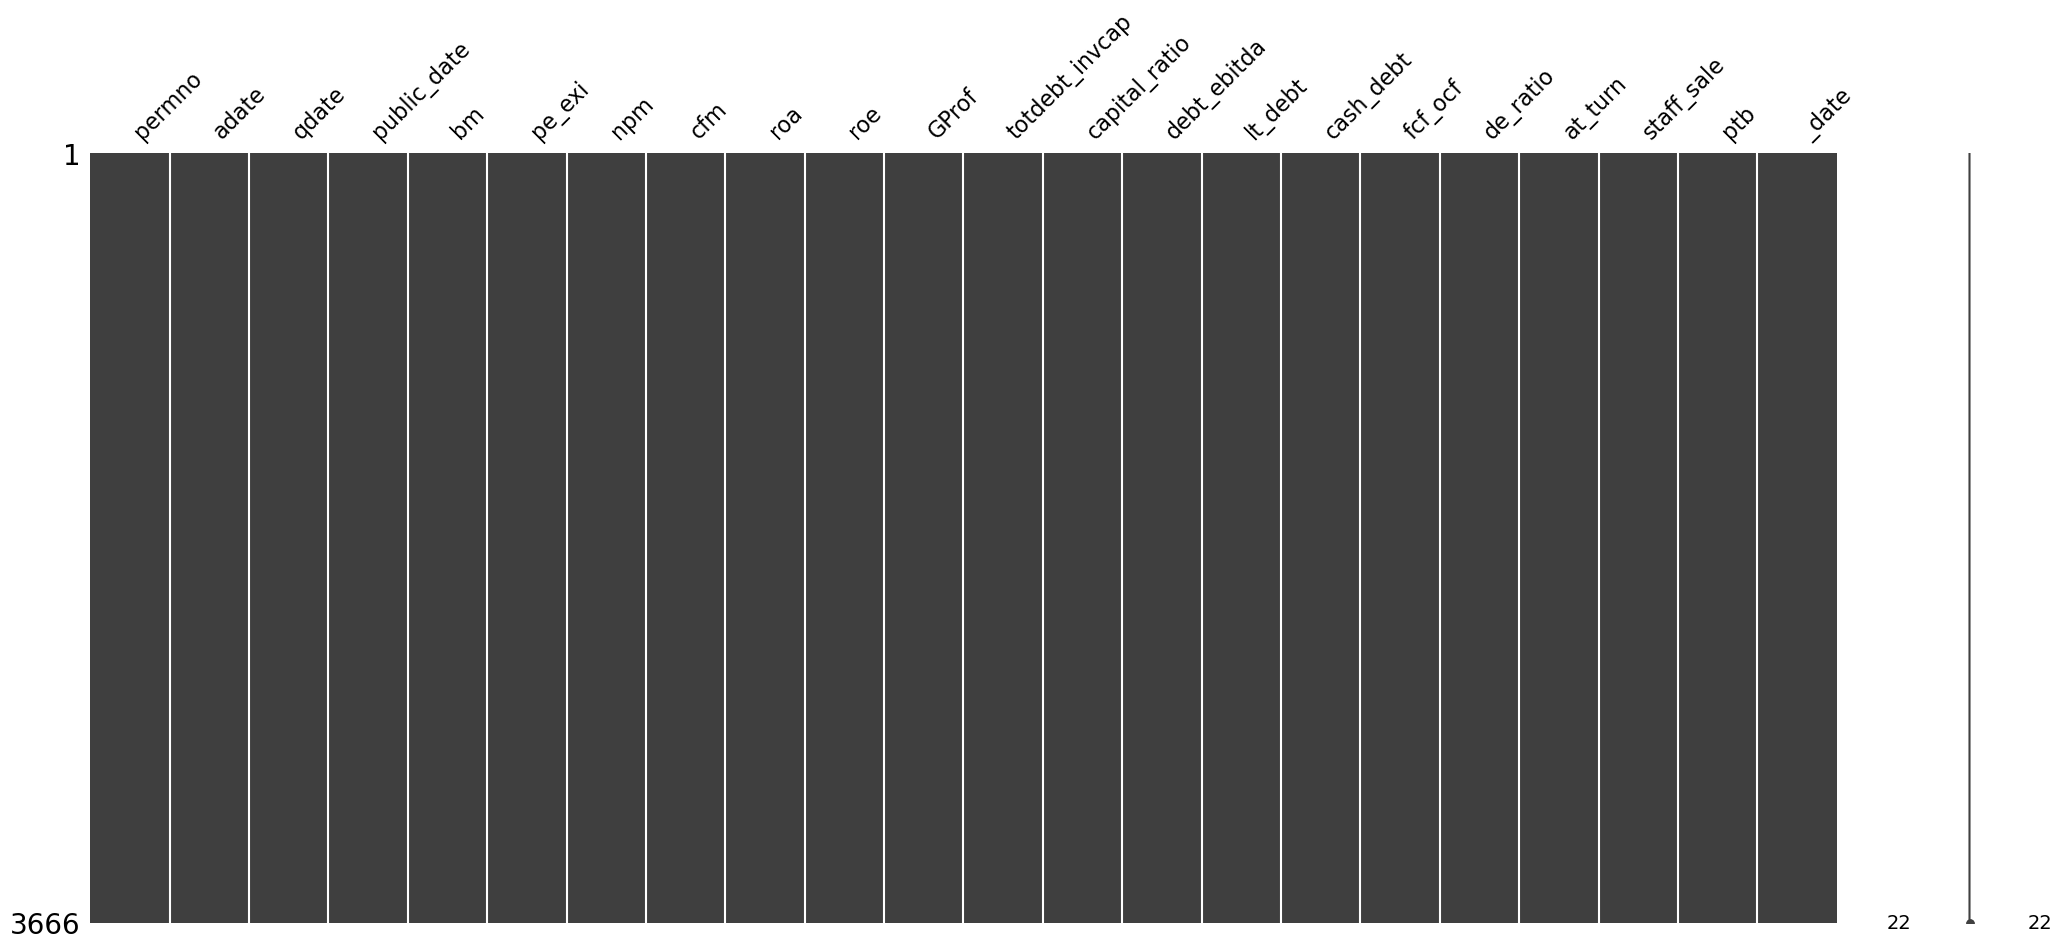

In [8]:
#visualize missing data
msno.matrix(ratios_train)

In [9]:
ratios_train.columns[4:-1]

Index(['bm', 'pe_exi', 'npm', 'cfm', 'roa', 'roe', 'GProf', 'totdebt_invcap',
       'capital_ratio', 'debt_ebitda', 'lt_debt', 'cash_debt', 'fcf_ocf',
       'de_ratio', 'at_turn', 'staff_sale', 'ptb'],
      dtype='object')

In [10]:
ratio_cols = ['permno'] + list(ratios_train.columns[4:-1])

In [11]:
ratio_cols

['permno',
 'bm',
 'pe_exi',
 'npm',
 'cfm',
 'roa',
 'roe',
 'GProf',
 'totdebt_invcap',
 'capital_ratio',
 'debt_ebitda',
 'lt_debt',
 'cash_debt',
 'fcf_ocf',
 'de_ratio',
 'at_turn',
 'staff_sale',
 'ptb']

In [12]:
#select only those columns
ratios_data = ratios_train.loc[:,ratios_train.columns.isin(ratio_cols)].reset_index(drop = True)
ratios_data.head()

,permno,bm,pe_exi,npm,cfm,roa,roe,GProf,totdebt_invcap,capital_ratio,debt_ebitda,lt_debt,cash_debt,fcf_ocf,de_ratio,at_turn,staff_sale,ptb
0,54594,1.119,-17.527,-0.037,0.036,0.029,-0.054,0.123,0.319,0.279,6.819,0.373,-0.064,-6.559227e+09,1.037,0.855,0.000,0.962
1,21020,0.151,6.059,0.119,0.157,0.191,1.471,0.325,0.929,0.851,2.188,0.399,0.074,1.320000e-01,14.358,0.888,0.225,7.032
2,11499,1.038,-384.000,-0.002,0.040,0.103,-0.003,0.216,0.418,0.379,3.222,0.434,0.070,9.290000e-01,1.405,0.722,0.000,0.904
3,81912,0.988,10.033,0.164,0.197,0.096,0.096,0.144,0.000,0.000,0.000,0.000,0.604,7.180000e-01,0.121,0.519,0.000,0.938
4,27991,1.057,17.911,0.115,0.279,0.089,0.056,0.088,0.470,0.424,2.893,0.329,0.112,-5.100000e-02,2.242,0.239,0.000,0.951


In [13]:
print("Number of stocks in ratios dataset: ", len(ratios_data))

Number of stocks in ratios dataset:  3666


In [14]:
ratios_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3666 entries, 0 to 3665
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   permno          3666 non-null   int64  
 1   bm              3666 non-null   float64
 2   pe_exi          3666 non-null   float64
 3   npm             3666 non-null   float64
 4   cfm             3666 non-null   float64
 5   roa             3666 non-null   float64
 6   roe             3666 non-null   float64
 7   GProf           3666 non-null   float64
 8   totdebt_invcap  3666 non-null   float64
 9   capital_ratio   3666 non-null   float64
 10  debt_ebitda     3666 non-null   float64
 11  lt_debt         3666 non-null   float64
 12  cash_debt       3666 non-null   float64
 13  fcf_ocf         3666 non-null   float64
 14  de_ratio        3666 non-null   float64
 15  at_turn         3666 non-null   float64
 16  staff_sale      3666 non-null   float64
 17  ptb             3666 non-null   f

In [68]:
#save training set to file
ratios_data.to_csv('ratios_data_table.csv')

In [69]:
#filtering stocks for testing dataset
testing_set = price_test.loc[price_test['PERMNO'].isin(list(set(ratios['permno'])))]
testing_set.head()

,PERMNO,TICKER,SICCD,date,PRC,RET,RETX,VOL,SHROUT,_date,turnover
5985,10026,JJSF,2052,20160104,113.09,-0.030685,-0.030685,80444.0,18677.0,2016-01-04,4.307116
5986,10026,JJSF,2052,20160105,112.43,-0.005836,-0.005836,45509.0,18677.0,2016-01-05,2.436633
5987,10026,JJSF,2052,20160106,112.67,0.002135,0.002135,53141.0,18677.0,2016-01-06,2.845264
5988,10026,JJSF,2052,20160107,110.82,-0.016420,-0.016420,48370.0,18677.0,2016-01-07,2.589816
5989,10026,JJSF,2052,20160108,110.59,-0.002075,-0.002075,86617.0,18677.0,2016-01-08,4.637629


In [70]:
testing_set.to_csv('tetsing_data.csv')